In [2]:
from sklearn.metrics import auc, plot_precision_recall_curve,precision_recall_curve
from sklearn.datasets import make_moons, make_blobs
from sklearn.metrics import average_precision_score
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score,roc_curve
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import svm
import matplotlib 
import seaborn as sns
import pandas as pd 
import numpy as np 
import random
import math
import time

import warnings
warnings.filterwarnings("ignore")

In [3]:
class GUClustering():
  def __init__(self):
    self.Y = None 
    self.X = None 
    
  def _cluster(self, Y, quantiles):
    quantiles = quantiles.reshape(-1,1)
    return np.argmin((abs(quantiles - Y)).T,axis=1) + 1 # starting from 1

  def fit(self,X):
    self.X = X
    self.Y = ((self.X[:,0] - np.mean(self.X[:,0])) ** 2) 
    for j in range(1,len(X[0])):
      self.Y += ((self.X[:,j] - np.mean(self.X[:,j])) ** 2) 
    self.Y = np.power(self.Y,0.5)
    self.Y = self.Y / self.Y.max() # convert between [0,1] (optional)

  def global_clustering(self,K=4):
    quantiles = np.quantile(self.Y,[k/K for k in range(K)])
    return self._cluster(self.Y,quantiles)
    
  def outlier_detection(self, q=0.95):
    threshold = np.quantile(self.Y,q)
    return ((self.Y > threshold)).astype(int)

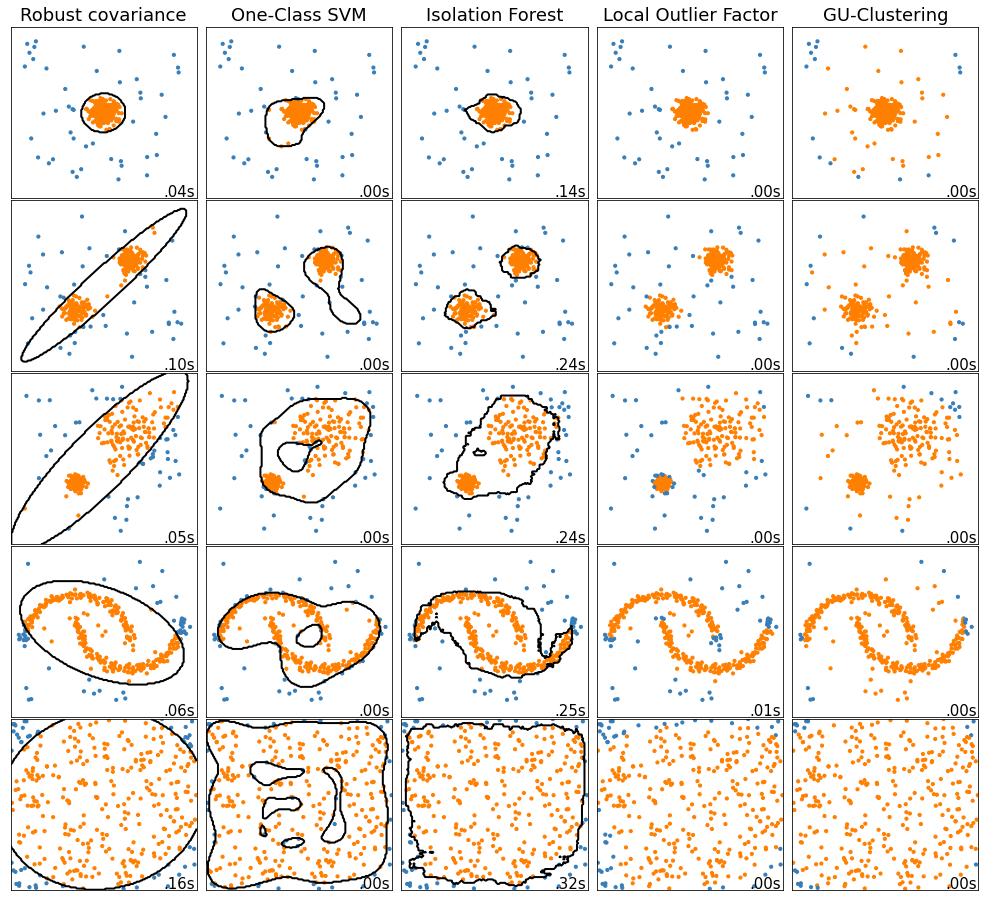

In [4]:
matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
    (
        "GU-Clustering", 
        GUClustering()
    )
]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        elif name == "GU-Clustering":
          y_pred = algorithm.outlier_detection(0.95)
          y_pred = np.array([1 if x == 0 else -1 for x in y_pred])
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name not in ["Local Outlier Factor","GU-Clustering"]:  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

In [5]:
min_max_scaler = MinMaxScaler()
# Datasets source:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OPQMVF

files = [
        '/breast-cancer-unsupervised-ad.csv',
        '/pen-global-unsupervised-ad.csv',
        '/letter-unsupervised-ad.csv', 
        '/speech-unsupervised-ad.csv', 
        '/satellite-unsupervised-ad.csv', 
        '/pen-local-unsupervised-ad.csv',
        '/annthyroid-unsupervised-ad.csv',
        '/shuttle-unsupervised-ad.csv',
        '/aloi-unsupervised-ad.csv',
        '/kdd99-unsupervised-ad.csv'
        ]

times = {
        "breast-cancer":[],"pen-global":[],"letter":[],"speech":[],"satellite":[],
        "pen-local":[],"annthyroid":[],"shuttle":[],"aloi":[],"kdd99":[]
        }

for f in files:
  name = f.split("-unsupervised")[0].split('/')[1]
  f = 'GU-Clustering/' + f
  df = pd.read_csv(f,header = None)
  df.columns = [*df.columns[:-1], 'Class']
  X = df.loc[:, df.columns != 'Class'].to_numpy()
  X = min_max_scaler.fit_transform(X) 
  df['labels'] = df['Class'].apply(lambda x: 1 if x == 'n' else -1)
  labels = df['labels'].tolist() 
  outliers_fraction = 1 - (len(df[df['labels'] == 1]) / len(df))
 
  t0 = time.time()
  GU = GUClustering()
  GU.fit(X)
  gu_predictions = GU.outlier_detection(q = 0.999)
  t1 = time.time()
  t = ("%.2fs" % (t1 - t0)).lstrip("0")
  times[name].append(t)
  # convert the labels to -1 and 1 as the other algorithms 
  gu_predictions = [1 if x == 0 else -1 for x in gu_predictions] 
  gu_auc = metrics.roc_auc_score(gu_predictions, labels)
  gu_f1 = round(f1_score(gu_predictions, labels),3)
  gu_acc = round(accuracy_score(gu_predictions, labels),3)
  
  t0 = time.time()
  lof = LocalOutlierFactor(contamination=outliers_fraction)
  lof_predictions = lof.fit_predict(X)
  t1 = time.time()
  t = ("%.2fs" % (t1 - t0)).lstrip("0")
  times[name].append(t)
  lof_auc = metrics.roc_auc_score(lof_predictions, labels)
  lof_f1 = round(f1_score(lof_predictions, labels),3)
  lof_acc = round(accuracy_score(lof_predictions, labels),3)
  
  t0 = time.time()
  clf = IsolationForest(contamination=outliers_fraction,random_state = 42)
  clf_predictions = clf.fit(X).predict(X)
  t1 = time.time()
  t = ("%.2fs" % (t1 - t0)).lstrip("0")
  times[name].append(t)
  clf_auc = metrics.roc_auc_score(clf_predictions, labels)
  clf_f1 = round(f1_score(clf_predictions, labels),3)
  clf_acc = round(accuracy_score(clf_predictions, labels),3)
  
  
  t0 = time.time()
  ell = EllipticEnvelope(contamination=outliers_fraction)
  ell_predictions = ell.fit(X).predict(X) 
  t1 = time.time()
  t = ("%.2fs" % (t1 - t0)).lstrip("0")
  times[name].append(t)
  ell_auc = metrics.roc_auc_score(ell_predictions, labels)
  ell_f1 = round(f1_score(ell_predictions, labels),3)
  ell_acc = round(accuracy_score(ell_predictions, labels),3)
  
  t0 = time.time()
  SVM = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma='scale')
  svm_predictions = SVM.fit(X).predict(X) 
  t1 = time.time()
  t = ("%.2fs" % (t1 - t0)).lstrip("0")
  times[name].append(t)
  svm_auc = metrics.roc_auc_score(svm_predictions, labels)
  svm_f1 = round(f1_score(svm_predictions, labels),3)
  svm_acc = round(accuracy_score(svm_predictions, labels),3)

  print(f"Results for {name} are:")
  print(f"GU-Clustering: AUC:{round(gu_auc,3)}, F1:{gu_f1}\
          LOF: AUC:{round(lof_auc,3)}, F1:{lof_f1}\
          iForest: AUC:{round(clf_auc,3)}, F1:{clf_f1}\
          oSVM: AUC:{round(svm_auc,3)}, F1:{svm_f1}\
          Robust Covariance: AUC:{round(ell_auc,3)}, F1:{ell_acc}")
          
  print('---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
  

Results for breast-cancer are:
GU-Clustering: AUC:0.988, F1:0.988          LOF: AUC:0.846, F1:0.992          iForest: AUC:0.794, F1:0.989          oSVM: AUC:0.603, F1:0.972          Robust Covariance: AUC:0.743, F1:0.973
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Results for pen-global are:
GU-Clustering: AUC:0.945, F1:0.942          LOF: AUC:0.706, F1:0.935          iForest: AUC:0.75, F1:0.944          oSVM: AUC:0.66, F1:0.924          Robust Covariance: AUC:0.6, F1:0.842
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Results for letter are:
GU-Clustering: AUC:0.469, F1:0.967          LOF: AUC:0.701, F1:0.963          iForest: AUC:0.509, F1:0.939          oSVM: AUC:0.544, F1:0.942          Robust Cov

In [6]:
# 6.1.1
CLUSTERS = 4
results = {}
X,y,centers = make_blobs(n_samples=1500,
                          n_features = 2,
                          center_box = (0,0),
                          centers = 1,
                          random_state=1, 
                          cluster_std = 0.275, 
                          return_centers = True) 

GU = GUClustering()
GU.fit(X)
gu_predictions = GU.global_clustering(K=CLUSTERS)
results['GU-Clustering'] = gu_predictions 

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=CLUSTERS, random_state=0).fit(X)
kmeans_predictions = kmeans.labels_
results['Kmeans'] = kmeans_predictions 

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=CLUSTERS, random_state=0).fit(X)
gm_predictions = gm.predict(X)
results['GMM'] = gm_predictions 

from sklearn.cluster import DBSCAN
dbscan_opt=DBSCAN(eps=0.01,min_samples=3)
dbscan_opt.fit(X)
dbscan_predictions = dbscan_opt.labels_
results['DBSCAN'] = dbscan_predictions 

for algo,predictions in results.items():
  X = np.array(X)
  df = pd.DataFrame({'feature1':X[:,0],'feature2':X[:,1],'clusters':predictions})
  df['avg_feature1'], df['avg_feature2'] = df['feature1'].mean(), df['feature2'].mean()
  df['distance_from_center'] = (((df['feature1'] - df['avg_feature1']) ** 2) + ((df['feature2'] - df['avg_feature2']) ** 2)) ** 0.5
  print(algo,df.groupby(['clusters'])[['distance_from_center']].mean())


GU-Clustering           distance_from_center
clusters                      
1                     0.069486
2                     0.191055
3                     0.325961
4                     0.534079
Kmeans           distance_from_center
clusters                      
0                     0.328900
1                     0.316788
2                     0.342972
3                     0.397745
GMM           distance_from_center
clusters                      
0                     0.489604
1                     0.374043
2                     0.274260
3                     0.280652
DBSCAN           distance_from_center
clusters                      
-1                    0.365277
 0                    0.161013
 1                    0.261425
 2                    0.173288
 3                    0.060539
...                        ...
 63                   0.107375
 64                   0.138680
 65                   0.326413
 66                   0.253406
 67                   0.145715

[69 ro

In [7]:
# 6.1.2
np.random.seed(42)
def CircularPoints(r,n=100):
    return [(math.cos(2*math.pi/n*x)*r+np.random.normal(-30,30),math.sin(2*math.pi/n*x)*r+np.random.normal(-30,30)) for x in range(1,n+1)]  
df=pd.DataFrame(CircularPoints(550,1000))
df=df.append(CircularPoints(300,500))
df=df.append(CircularPoints(60,300))
df=df.append(CircularPoints(900,1320))
X = df.to_numpy()
results = {}

GU = GUClustering()
GU.fit(X)
gu_predictions = GU.global_clustering(K=CLUSTERS)
results['GU-Clustering'] = gu_predictions 

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
kmeans_predictions = kmeans.labels_
results['Kmeans'] = kmeans_predictions

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=4, random_state=0,).fit(X)
gm_predictions = gm.predict(X)
results['GMM'] = gm_predictions

from sklearn.cluster import DBSCAN
dbscan_opt=DBSCAN(eps=79,min_samples=4)
dbscan_opt.fit(X)
dbscan_predictions = dbscan_opt.labels_
results['DBSCAN'] = dbscan_predictions

for algo,predictions in results.items():
  X = np.array(X)
  df = pd.DataFrame({'feature1':X[:,0],'feature2':X[:,1],'clusters':predictions})
  df['avg_feature1'], df['avg_feature2'] = df['feature1'].mean(), df['feature2'].mean()
  df['distance_from_center'] = (((df['feature1'] - df['avg_feature1']) ** 2) + ((df['feature2'] - df['avg_feature2']) ** 2)) ** 0.5
  print(algo,df.groupby(['clusters'])[['distance_from_center']].mean())

GU-Clustering           distance_from_center
clusters                      
1                    70.595498
2                   301.292524
3                   548.977896
4                   900.732364
Kmeans           distance_from_center
clusters                      
0                   690.530882
1                   693.709794
2                   639.827443
3                   486.488124
GMM           distance_from_center
clusters                      
0                   784.786294
1                   777.622909
2                   410.707741
3                   696.204057
DBSCAN           distance_from_center
clusters                      
0                   548.977896
1                   301.292524
2                    70.595498
3                   900.732364


In [8]:
# 6.1.3
CLUSTERS = 4
results = {}
X, y,centers = make_blobs(n_samples=1500,
                          n_features = 2,
                          centers = 4,
                          random_state=1,
                          return_centers = True) 

GU = GUClustering()
GU.fit(X)
gu_predictions = GU.global_clustering(K=CLUSTERS)
results['GU-Clustering'] = gu_predictions 

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=CLUSTERS, random_state=0).fit(X)
kmeans_predictions = kmeans.labels_
results['Kmeans'] = kmeans_predictions 

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=CLUSTERS, random_state=0).fit(X)
gm_predictions = gm.predict(X)
results['GMM'] = gm_predictions 

from sklearn.cluster import DBSCAN
dbscan_opt=DBSCAN(eps=0.01,min_samples=2)
dbscan_opt.fit(X)
dbscan_predictions = dbscan_opt.labels_
results['DBSCAN'] = dbscan_predictions 

for algo,predictions in results.items():
  X = np.array(X)
  df = pd.DataFrame({'feature1':X[:,0],'feature2':X[:,1],'clusters':predictions})
  df['avg_feature1'], df['avg_feature2'] = df['feature1'].mean(), df['feature2'].mean()
  df['distance_from_center'] = (((df['feature1'] - df['avg_feature1']) ** 2) + ((df['feature2'] - df['avg_feature2']) ** 2)) ** 0.5
  print(algo,df.groupby(['clusters'])[['distance_from_center']].mean())

GU-Clustering           distance_from_center
clusters                      
1                     0.781990
2                     2.376011
3                     4.788450
4                     8.005162
Kmeans           distance_from_center
clusters                      
0                     4.003823
1                     8.562461
2                     5.667337
3                     1.283965
GMM           distance_from_center
clusters                      
0                     3.993087
1                     8.562461
2                     5.667337
3                     1.280290
DBSCAN           distance_from_center
clusters                      
-1                    4.882126
 0                    8.437976
 1                    1.421580
 2                    1.837429
 3                    5.066210
 4                    6.905340
 5                    0.274010
 6                    6.043293
 7                    5.360915


In [9]:
# 6.1.5
CLUSTERS = 3
results = {}
X,y,centers = make_blobs(n_samples=1000,
                  center_box = (0,0,0),
                  centers=3,
                  cluster_std = 1,
                  n_features=3,
                  random_state=2, 
                  return_centers = True)

GU = GUClustering()
GU.fit(X)
gu_predictions = GU.global_clustering(K=CLUSTERS)
results['GU-Clustering'] = gu_predictions 

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=CLUSTERS, random_state=0).fit(X)
kmeans_predictions = kmeans.labels_
results['Kmeans'] = kmeans_predictions

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=CLUSTERS, random_state=0).fit(X)
gm_predictions = gm.predict(X)
results['GMM'] = gm_predictions

from sklearn.cluster import DBSCAN
dbscan_opt=DBSCAN(eps=0.25,min_samples=CLUSTERS)
dbscan_opt.fit(X)
dbscan_predictions = dbscan_opt.labels_
results['DBSCAN'] = dbscan_predictions

for algo,predictions in results.items():
  X = np.array(X)
  df = pd.DataFrame({'feature1':X[:,0],'feature2':X[:,1],'feature3':X[:,2],'clusters':predictions})
  df['avg_feature1'], df['avg_feature2'],df['avg_feature3'] = df['feature1'].mean(), df['feature2'].mean(), df['feature3'].mean()
  df['distance_from_center'] = (((df['feature1'] - df['avg_feature1']) ** 2) + ((df['feature2'] - df['avg_feature2']) ** 2) + ((df['feature3'] - df['avg_feature3']) ** 2)) ** 0.5
  print(algo,df.groupby(['clusters'])[['distance_from_center']].mean())

GU-Clustering           distance_from_center
clusters                      
1                     0.543749
2                     1.170836
3                     2.166083
Kmeans           distance_from_center
clusters                      
0                     1.579950
1                     1.647713
2                     1.610642
GMM           distance_from_center
clusters                      
0                     1.459980
1                     1.640822
2                     1.725144
DBSCAN           distance_from_center
clusters                      
-1                    2.032338
 0                    1.001659
 1                    1.521860
 2                    1.464052
 3                    1.633122
 4                    1.105478
 5                    1.409359
 6                    1.638816
 7                    1.302940
 8                    0.911506
 9                    1.156182
 10                   1.365465
 11                   1.064975
 12                   1.336781
 13    

In [10]:
# Dataset: Car Price Prediction Multiple Linear Regression
# https://www.kaggle.com/datasets/hellbuoy/car-price-prediction

df = pd.read_csv('/GU-Clustering/CarPrice_Assignment.csv')

# Drop non-numeric columns from the dataframe and repalce missing values with the column median
columns = df.columns.values
cols_to_drop = []
for column in columns:
  if df[column].dtype not in (np.int64,np.float64):
    cols_to_drop.append(column)
  else:
    df[column] = df[column].fillna(df[column].median())
df.drop(cols_to_drop, axis=1, inplace=True)
del df['car_ID']
price = df['price']

X = df.loc[:, df.columns != 'price'].to_numpy()

GU = GUClustering()
GU.fit(X)
gu_predictions = GU.global_clustering(K=5)
df['predictions'] = gu_predictions # add the predictions to the dataframe

df2 = df.loc[df['predictions'] != 5] # remove the outermost group from the center in the new dataframe 
del df['predictions']; del df2['predictions'] # delete the predictions column 
new_price = df2['price'].tolist() # get the labels for the new dataframe 
del df2['price']

price = df['price'].tolist()
del df['price']
reg = LinearRegression().fit(df,price)
print(f'R squared from the original dataframe is {reg.score(df,price)}')


reg = LinearRegression().fit(df2,new_price,)
print(f'R squared from the revised dataframe is {reg.score(df2,new_price)}')


R squared from the original dataframe is 0.8518688522642911
R squared from the revised dataframe is 0.8357124243882221


In [11]:
# Dataset: Weather Data for Linear Regression 
# https://www.kaggle.com/datasets/zakriarehman/weather-data-for-linear-regression

df = pd.read_csv('/GU-Clustering/weather.csv')
del df['Description'] # non-numeric
X = df.loc[:, df.columns != 'Temperature_c'].to_numpy()
temperature = df['Temperature_c'].to_numpy() #labels

GU = GUClustering()
GU.fit(X)
gu_predictions = GU.global_clustering(K=5)
df['predictions'] = gu_predictions # add the predictions to the dataframe

df2 = df.loc[df['predictions'] != 5] 
del df['predictions']; del df2['predictions']
temperature2 = df2['Temperature_c'].reset_index(drop=True)
del df2['Temperature_c']; del df['Temperature_c']

# Fit the model to the original df
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(df, temperature)
print(f'R squared from the original dataframe is {reg.score(df, temperature)}')

reg = LinearRegression().fit(df2, temperature2)
print(f'R squared from the revised dataframe is {reg.score(df2, temperature2)}')

R squared from the original dataframe is 0.6028029112077455
R squared from the revised dataframe is 0.6500131878781876


In [12]:
# Dataset: House Prices - Advanced Regression Techniques
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques

df = pd.read_csv('/GU-Clustering/train.csv')
sale_price = df['SalePrice'].reset_index(drop=True)

# Drop columns with more than 40% missing data 
cols_to_drop = []
for column in df:
  if df[column].isnull().sum() / len(df) >= 0.4:
    cols_to_drop.append(column)
df.drop(cols_to_drop, axis=1, inplace=True)

# Drop non-numeric columns from the dataframe and repalce missing values with the column median
columns = df.columns.values
cols_to_drop = []
for column in columns:
  if df[column].dtype not in (np.int64,np.float64):
    cols_to_drop.append(column)
  else:
    df[column] = df[column].fillna(df[column].median())
df.drop(cols_to_drop, axis=1, inplace=True)
del df['Id'] #delete the id column 


X = df.loc[:, df.columns != 'SalePrice'].to_numpy()

GU = GUClustering()
GU.fit(X)
gu_predictions = GU.global_clustering(K=5)
df['predictions'] = gu_predictions

df2 = df.loc[df['predictions'] != 5] # remove the outermost group from the center in the new dataframe 
del df['predictions']; del df2['predictions'] # delete the predictions column 
sale_price_2 = df2['SalePrice'].reset_index(drop=True) # get the labels for the new dataframe 
del df2['SalePrice'] # delete the labels 

# Fit the model to the original df
from sklearn.linear_model import LinearRegression
del df['SalePrice'] 
reg = LinearRegression().fit(df, sale_price)
print(f'R squared from the original dataframe is {reg.score(df, sale_price)}')

# Fit the model to the revised dataset 
reg = LinearRegression().fit(df2, sale_price_2)
print(f'R squared from the revised dataframe is {reg.score(df2, sale_price_2)}')

R squared from the original dataframe is 0.8131543788138269
R squared from the revised dataframe is 0.8686134110894324
